### Import dependencies

In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from datetime import datetime

### Get dataset

In [2]:
data = pd.read_csv('../reduced.csv')
data.drop('Index', axis=1, inplace=True)
data.head()

,0,7,13,14,17,33,37,39,40,46,...,387,388,390,398,402,405,409,415,466,labels
0,0.156041,0.290654,0.199809,0.290295,0.356657,0.307132,0.157192,0.187702,0.217832,0.374565,...,0.309477,0.318458,0.295038,0.212476,0.284568,0.338188,0.244253,0.234073,0.323322,0
1,0.099105,0.332776,0.119696,0.208098,0.258650,0.352134,0.101318,0.130601,0.152025,0.427157,...,0.343032,0.350165,0.319125,0.251888,0.207328,0.249380,0.196100,0.174136,0.353529,0
2,0.160259,0.224147,0.209884,0.213498,0.264495,0.233589,0.151807,0.161886,0.180539,0.275579,...,0.364269,0.375077,0.351450,0.293468,0.241386,0.285400,0.268769,0.265217,0.382837,0
3,0.139705,0.330197,0.172731,0.188332,0.243490,0.348977,0.137025,0.159584,0.179181,0.438886,...,0.341322,0.349891,0.321454,0.252637,0.197635,0.243881,0.215141,0.200392,0.354787,0
4,0.144930,0.312308,0.172522,0.174161,0.215116,0.328316,0.152421,0.181887,0.210446,0.382999,...,0.197266,0.195961,0.176641,0.165296,0.164141,0.196522,0.158438,0.156289,0.194182,0


### Split data

In [3]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

### Model builder

In [4]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=92))

    for i in range(hp.Int('layers', 2, 6)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                    activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
     
    model.add(layers.Dense(6, activation="softmax"))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

    return model


### Set hyper parameter tuner

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='./DeepNet',
                     project_name='Reduced')

### Add an early stopping stage

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Search for the best layers number, neurons per layer and learning rate

In [ ]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

### Review top 10 best models 

In [9]:
tuner.results_summary()

Results summary
Results in ./DeepNet\Reduced
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 3
units_0: 256
act_0: relu
units_1: 448
act_1: relu
learning_rate: 0.0001
units_2: 448
act_2: relu
units_3: 448
act_3: sigmoid
units_4: 320
act_4: sigmoid
units_5: 64
act_5: sigmoid
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5076923370361328
Trial summary
Hyperparameters:
layers: 3
units_0: 448
act_0: relu
units_1: 384
act_1: relu
learning_rate: 0.0001
units_2: 96
act_2: relu
units_3: 480
act_3: relu
units_4: 512
act_4: relu
units_5: 64
act_5: relu
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 84b2dbb4ef5614a9a110196593e5dbe2
Score: 0.49057692289352417
Trial summary
Hyperparameters:
layers: 6
units_0: 320
act_0: relu
units_1: 384
act_1: relu
learning_rate: 0.0001
units_2: 320
act_2: relu
units_3: 160
act_3: relu
units_4: 96
act_4: relu
units_5: 320
act

### Reproduce best model

In [10]:
model = keras.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_dim=92))
model.add(layers.Dense(units=448, activation='relu'))
model.add(layers.Dense(units=448, activation='relu'))    
model.add(layers.Dense(6, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               23808     
                                                                 
 dense_5 (Dense)             (None, 448)               115136    
                                                                 
 dense_6 (Dense)             (None, 448)               201152    
                                                                 
 dense_7 (Dense)             (None, 6)                 2694      
                                                                 
Total params: 342,790
Trainable params: 342,790
Non-trainable params: 0
_________________________________________________________________


### Optimize the batch size and epochs 

In [12]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
	model = keras.Sequential()
	model.add(layers.Dense(units=256, activation='relu', input_dim=92))
	model.add(layers.Dense(units=448, activation='relu'))
	model.add(layers.Dense(units=448, activation='relu'))    
	model.add(layers.Dense(6, activation="softmax"))
	
	model.compile(
		optimizer=keras.optimizers.Adam(learning_rate= 0.0001),
		loss="sparse_categorical_crossentropy",
		metrics=['accuracy'],
	)
	return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

C:\Users\andyg\anaconda3\envs\faces\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


### Show models resume

In [13]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.510539 using {'batch_size': 20, 'epochs': 100}
0.470882 (0.008931) with: {'batch_size': 10, 'epochs': 10}
0.502885 (0.006089) with: {'batch_size': 10, 'epochs': 50}
0.507154 (0.002638) with: {'batch_size': 10, 'epochs': 100}
0.463920 (0.008287) with: {'batch_size': 20, 'epochs': 10}
0.500846 (0.006610) with: {'batch_size': 20, 'epochs': 50}
0.510539 (0.002048) with: {'batch_size': 20, 'epochs': 100}
0.458689 (0.010281) with: {'batch_size': 40, 'epochs': 10}
0.499538 (0.003203) with: {'batch_size': 40, 'epochs': 50}
0.502192 (0.005167) with: {'batch_size': 40, 'epochs': 100}
0.450265 (0.001947) with: {'batch_size': 60, 'epochs': 10}
0.496769 (0.008012) with: {'batch_size': 60, 'epochs': 50}
0.509155 (0.004692) with: {'batch_size': 60, 'epochs': 100}
0.439111 (0.007576) with: {'batch_size': 80, 'epochs': 10}
0.493115 (0.009000) with: {'batch_size': 80, 'epochs': 50}
0.501692 (0.009289) with: {'batch_size': 80, 'epochs': 100}
0.426725 (0.015799) with: {'batch_size': 100, 'epochs':

### Get best optimizer

In [14]:
def create_model(optimizer='adam'):
	model = keras.Sequential()
	model.add(layers.Dense(units=256, activation='relu', input_dim=92))
	model.add(layers.Dense(units=448, activation='relu'))
	model.add(layers.Dense(units=448, activation='relu'))    
	model.add(layers.Dense(6, activation="softmax"))
	
	model.compile(
		optimizer=optimizer,
		loss="sparse_categorical_crossentropy",
		metrics=['accuracy'],
	)
	return model

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

C:\Users\andyg\anaconda3\envs\faces\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  from ipykernel import kernelapp as app


### Show models resume

In [15]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.507424 using {'optimizer': 'Adamax'}
0.493576 (0.009201) with: {'optimizer': 'SGD'}
0.435610 (0.022329) with: {'optimizer': 'RMSprop'}
0.437918 (0.004268) with: {'optimizer': 'Adagrad'}
0.266559 (0.003022) with: {'optimizer': 'Adadelta'}
0.481345 (0.012709) with: {'optimizer': 'Adam'}
0.507424 (0.007970) with: {'optimizer': 'Adamax'}
0.489961 (0.006561) with: {'optimizer': 'Nadam'}


In [ ]:
%load_ext tensorboard

### Train model based on the previous hyperparameter, graph its learning curve  

In [16]:
logdir="./logs/optimizer" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

model = keras.Sequential()
model.add(layers.Dense(units=256, activation='relu', input_dim=92))
model.add(layers.Dense(units=488, activation='relu'))
model.add(layers.Dense(units=488, activation='relu'))    
model.add(layers.Dense(6, activation="softmax"))

model.compile(
	optimizer=keras.optimizers.Adamax(learning_rate=0.0001),
	loss="sparse_categorical_crossentropy",
	metrics=['accuracy'],
)

batch_size = 20
history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=batch_size,
    verbose=1, 
    epochs=100,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback],
)

Epoch 1/100
975/975 [==============================] - 4s 4ms/step - loss: 1.7449 - accuracy: 0.2652 - val_loss: 1.7308 - val_accuracy: 0.2617
Epoch 2/100
975/975 [==============================] - 3s 3ms/step - loss: 1.7208 - accuracy: 0.2722 - val_loss: 1.7031 - val_accuracy: 0.2920
Epoch 3/100
975/975 [==============================] - 3s 3ms/step - loss: 1.6874 - accuracy: 0.2952 - val_loss: 1.6588 - val_accuracy: 0.3323
Epoch 4/100
975/975 [==============================] - 3s 3ms/step - loss: 1.6424 - accuracy: 0.3449 - val_loss: 1.6209 - val_accuracy: 0.3178
Epoch 5/100
975/975 [==============================] - 4s 4ms/step - loss: 1.5985 - accuracy: 0.3749 - val_loss: 1.5709 - val_accuracy: 0.3865
Epoch 6/100
975/975 [==============================] - 3s 3ms/step - loss: 1.5614 - accuracy: 0.3946 - val_loss: 1.5353 - val_accuracy: 0.4086
Epoch 7/100
975/975 [==============================] - 3s 3ms/step - loss: 1.5315 - accuracy: 0.4091 - val_loss: 1.5308 - val_accuracy: 0.4185

### Test the model with the testing set

In [17]:
predictions = model.predict(x_test)
predictions = keras.backend.argmax(
    predictions,
    axis=-1
)

### Get the accuracy score

In [18]:
accuracy_score(y_test, predictions)

0.4950769230769231

### Get the confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix(y_test, predictions)

array([[ 227,   19,  149,  195,  242,   44],
       [  83,   50,  160,  234,  327,  111],
       [  30,    7, 1401,  127,  120,   28],
       [  71,   16,   75,  605,  376,   28],
       [  59,   23,  122,  263,  544,   12],
       [  33,   31,   88,  166,   43,  391]], dtype=int64)

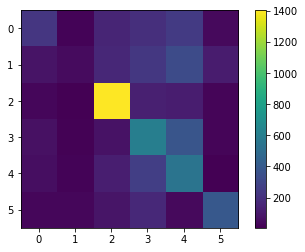

In [31]:
plt.imshow(confusion_matrix(y_test, predictions))
plt.colorbar()

### Get the recall 

In [28]:
from sklearn.metrics import recall_score
recall_score(y_test, predictions, average=None)

array([0.25913242, 0.05181347, 0.8178634 , 0.51665243, 0.53176931,
       0.51994681])

### Get Precision

In [29]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions, average=None)

array([0.45129225, 0.34246575, 0.70225564, 0.38050314, 0.32929782,
       0.63680782])